# Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


# Creating Initial Variables

### Designating CPTAC Variables

In [2]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
transcriptomics = CPTAC.get_transcriptomics()

### Designating a List of TP53 Hotspot Mutations Found in a Previous Analysis

In [3]:
# A list of mutations present in the hotspot according to our Hotspot3D output
gene = 'TP53'
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W','p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

# Unique Protein Analysis

### Designating Arrays of unique Proteins Found in a Previous Analysis

In [20]:
# Creating a list for the unique correlations in all TP53 mutants vs wildtype analysis
all_mut_prot_array = np.array(['AES', 'AKAP8L', 'BIN3', 'BIRC2', 'BUB1B', 'CBS', 'CDK11B', 'CDYL', 'CEBPZ', 'CHD4', 'COPS4', 'CRADD', 'DDX18', 'DDX39A', 'DDX52', 'DLG5', 'DLGAP5', 'ECT2', 'EIF4G1', 'ESF1', 'FBXO22', 'FMN1', 'FXR1', 'GEMIN2', 'GFM1', 'GMPR2', 'GMPS', 'HEATR1', 'HMCES', 'IFIT2', 'KDM2A', 'KIF2C', 'KIFC1', 'MDC1', 'MTUS1', 'NAA25', 'NCL', 'NOL11', 'NOL7', 'NOM1', 'OAS3', 'PA2G4', 'PAK2', 'PAXX', 'PBLD', 'PDCD11', 'PICK1', 'PLCE1', 'PRRC2A', 'PSMD5', 'PTAR1', 'PTPN2', 'PUF60', 'RAB5IF', 'RABL6', 'RBBP6', 'RCC2', 'RIF1', 'RRP1B', 'RRP36', 'SCRN3', 'SDF2', 'SEC16A', 'SEPSECS', 'SGSM3', 'SMG1', 'SMPD1', 'TAF2', 'TOLLIP', 'TOP1', 'TOP2A', 'TPX2', 'TRAF3IP2', 'TRIM2', 'TRIP13', 'TRMT10C', 'TRMT6', 'TTC4', 'UBR5', 'USP47', 'UTP3', 'UTP4', 'VPS13C', 'VPS25', 'VPS36', 'VRK1', 'WDR43', 'WDR75', 'XPO1', 'XRN1', 'ZC3H8', 'ZCCHC17', 'ZNF217', 'ZNF622'])
all_mut_tran_array = np.array(['AAMP', 'ABCF3', 'ABHD16B', 'ABHD18', 'ACAD9', 'ACAP2', 'ADAM17', 'ADRM1', 'AEN', 'AIP', 'ALG3', 'ANKFN1', 'ANKHD1-EIF4EBP3', 'ANKLE1', 'ANKRA2', 'ANKRD27', 'AP2M1', 'ARFGAP1', 'ARFRP1', 'ARHGAP26-IT1', 'ARMC8', 'ARSD', 'ATAD3B', 'ATL2', 'AURKA', 'BABAM1', 'BAK1', 'BBS4', 'BYSL', 'C20orf27', 'C6orf106', 'C9orf152', 'CABLES2', 'CASC4', 'CCDC124', 'CDCA8', 'CDK5RAP1', 'CDKN1A', 'CENPA', 'CENPO', 'CHRAC1', 'CKS1B', 'CLCN2', 'COG3', 'COL28A1', 'COLCA1', 'COLCA2', 'COLGALT1', 'CSNK2A1', 'CSNK2B', 'CSTF1', 'CTCFL', 'CTNNBL1', 'CYB5D2', 'DAXX', 'DCAF15', 'DERL1', 'DHX16', 'DNAJB11', 'DNMBP', 'DPH2', 'E2F1', 'E2F3', 'EEFSEC', 'EFL1', 'EHMT2', 'EIF4A3', 'ERCC3', 'ERCC6L2', 'ERI3', 'ERICH3', 'ESPL1', 'FAAP24', 'FAM131A', 'FAM149A', 'FAM214A', 'FAM219B', 'FAM83D', 'FBXO45', 'FGF21', 'FKBPL', 'FNDC7', 'FSD1', 'FYTTD1', 'GALNT7', 'GGCX', 'GID8', 'GMEB2', 'GOLGA1', 'GPATCH3', 'GPN1', 'GRAMD2B', 'GSTM2P1', 'GTF3C2', 'GTPBP3', 'HAUS5', 'HMGA1', 'HNF4G', 'HPDL', 'HSD17B4', 'HSDL2', 'HSF2BP', 'HSP90AB1', 'IDH3B', 'IFI44L', 'IFT88', 'IGF2BP1', 'IL20RA', 'INVS', 'IRF7', 'ISY1', 'ISYNA1', 'KBTBD4', 'KIAA1324', 'KIF27', 'KLHDC3', 'KPNA1', 'KPNA4', 'LAMP3', 'LEMD2', 'LINC00271', 'LNP1', 'LOC100128966', 'LOC101927391', 'LOC283177', 'LOC285191', 'LOC399815', 'LOC728485', 'LRP2BP', 'MAGEF1', 'MAN2A1', 'MAP6D1', 'MAPRE1', 'MARVELD2', 'MAST1', 'MCM8', 'MDM2', 'MED20', 'MEGF9', 'MEIOB', 'MGME1', 'MIIP', 'MIS18A', 'MRAP2', 'MRPL2', 'MRPL3', 'MRPL4', 'MSX1', 'MTBP', 'MTCH1', 'MTFR2', 'MTG2', 'MYCL', 'NAA50', 'NCBP2', 'NCBP2-AS2', 'NEIL1', 'NELFCD', 'NMRK1', 'NOP56', 'NPBWR2', 'NR2F6', 'NT5E', 'NUP155', 'NXT1', 'OASL', 'OR5H6', 'OSBPL2', 'PARL', 'PBX2', 'PDRG1', 'PEPD', 'PFDN4', 'PFDN6', 'PGR', 'PHKB', 'PIGU', 'PIK3R4', 'PNO1', 'POLK', 'POLQ', 'PSMA7', 'PSMD2', 'PSMF1', 'PSPC1', 'RAB14', 'RAD21', 'RALY', 'RBM42', 'RFC4', 'RNF114', 'RNF168', 'RNF26', 'RPP40', 'RPRD1B', 'RPS27L', 'RRAGC', 'RSAD2', 'RTF2', 'SECISBP2', 'SECISBP2L', 'SENP5', 'SESN1', 'SGCB', 'SHKBP1', 'SKIV2L', 'SLC30A6', 'SMIM13', 'SMPD4', 'SNORA93', 'SNRNP200', 'SNRPB', 'SNRPB2', 'SNRPC', 'SOX11', 'SPATA18', 'SPATA6', 'SPDEF', 'SPG11', 'SPNS1', 'SS18L1', 'SSSCA1', 'STX17', 'SUMO3', 'TAF11', 'TAF4', 'TBC1D31', 'TBL1XR1', 'TET2', 'TFG', 'THEMIS2', 'TIGD4', 'TIRAP', 'TLE6', 'TM9SF4', 'TMC5', 'TMEM147', 'TMEM41A', 'TMEM62', 'TNK2', 'TOMM40', 'TRAIP', 'TRIM13', 'TRIM32', 'TRIM39', 'TRMO', 'TRPC4AP', 'TTC12', 'TTC23', 'TTC38', 'TUBA1C', 'UBE2S', 'UBR1', 'UCKL1', 'UNC5C', 'UQCC2', 'USE1', 'WDR46', 'WDR53', 'WRNIP1', 'XPA', 'XPC', 'YEATS2', 'YY1', 'ZBTB9', 'ZFAT', 'ZFP64', 'ZNF165', 'ZNF280D', 'ZNF850', 'ZSWIM1', 'ZXDC', 'ZYG11A'])
all_mut_unique_array = np.array(['AES', 'AKAP8L', 'BIN3', 'BIRC2', 'BUB1B', 'CBS', 'CDK11B', 'CDYL', 'CEBPZ', 'CHD4', 'COPS4', 'CRADD', 'DDX18', 'DDX39A', 'DDX52', 'DLG5', 'DLGAP5', 'ECT2', 'EIF4G1', 'ESF1', 'FBXO22', 'FMN1', 'FXR1', 'GEMIN2', 'GFM1', 'GMPR2', 'GMPS', 'HEATR1', 'HMCES', 'IFIT2', 'KDM2A', 'KIF2C', 'KIFC1', 'MDC1', 'MTUS1', 'NAA25', 'NCL', 'NOL11', 'NOL7', 'NOM1', 'OAS3', 'PA2G4', 'PAK2', 'PAXX', 'PBLD', 'PDCD11', 'PICK1', 'PLCE1', 'PRRC2A', 'PSMD5', 'PTAR1', 'PTPN2', 'PUF60', 'RAB5IF', 'RABL6', 'RBBP6', 'RCC2', 'RIF1', 'RRP1B', 'RRP36', 'SCRN3', 'SDF2', 'SEC16A', 'SEPSECS', 'SGSM3', 'SMG1', 'SMPD1', 'TAF2', 'TOLLIP', 'TOP1', 'TOP2A', 'TPX2', 'TRAF3IP2', 'TRIM2', 'TRIP13', 'TRMT10C', 'TRMT6', 'TTC4', 'UBR5', 'USP47', 'UTP3', 'UTP4', 'VPS13C', 'VPS25', 'VPS36', 'VRK1', 'WDR43', 'WDR75', 'XPO1', 'XRN1', 'ZC3H8', 'ZCCHC17', 'ZNF217', 'ZNF622', 'AAMP', 'ABCF3', 'ABHD16B', 'ABHD18', 'ACAD9', 'ACAP2', 'ADAM17', 'ADRM1', 'AEN', 'AIP', 'ALG3', 'ANKFN1', 'ANKHD1-EIF4EBP3', 'ANKLE1', 'ANKRA2', 'ANKRD27', 'AP2M1', 'ARFGAP1', 'ARFRP1', 'ARHGAP26-IT1', 'ARMC8', 'ARSD', 'ATAD3B', 'ATL2', 'AURKA', 'BABAM1', 'BAK1', 'BBS4', 'BYSL', 'C20orf27', 'C6orf106', 'C9orf152', 'CABLES2', 'CASC4', 'CCDC124', 'CDCA8', 'CDK5RAP1', 'CDKN1A', 'CENPA', 'CENPO', 'CHRAC1', 'CKS1B', 'CLCN2', 'COG3', 'COL28A1', 'COLCA1', 'COLCA2', 'COLGALT1', 'CSNK2A1', 'CSNK2B', 'CSTF1', 'CTCFL', 'CTNNBL1', 'CYB5D2', 'DAXX', 'DCAF15', 'DERL1', 'DHX16', 'DNAJB11', 'DNMBP', 'DPH2', 'E2F1', 'E2F3', 'EEFSEC', 'EFL1', 'EHMT2', 'EIF4A3', 'ERCC3', 'ERCC6L2', 'ERI3', 'ERICH3', 'ESPL1', 'FAAP24', 'FAM131A', 'FAM149A', 'FAM214A', 'FAM219B', 'FAM83D', 'FBXO45', 'FGF21', 'FKBPL', 'FNDC7', 'FSD1', 'FYTTD1', 'GALNT7', 'GGCX', 'GID8', 'GMEB2', 'GOLGA1', 'GPATCH3', 'GPN1', 'GRAMD2B', 'GSTM2P1', 'GTF3C2', 'GTPBP3', 'HAUS5', 'HMGA1', 'HNF4G', 'HPDL', 'HSD17B4', 'HSDL2', 'HSF2BP', 'HSP90AB1', 'IDH3B', 'IFI44L', 'IFT88', 'IGF2BP1', 'IL20RA', 'INVS', 'IRF7', 'ISY1', 'ISYNA1', 'KBTBD4', 'KIAA1324', 'KIF27', 'KLHDC3', 'KPNA1', 'KPNA4', 'LAMP3', 'LEMD2', 'LINC00271', 'LNP1', 'LOC100128966', 'LOC101927391', 'LOC283177', 'LOC285191', 'LOC399815', 'LOC728485', 'LRP2BP', 'MAGEF1', 'MAN2A1', 'MAP6D1', 'MAPRE1', 'MARVELD2', 'MAST1', 'MCM8', 'MDM2', 'MED20', 'MEGF9', 'MEIOB', 'MGME1', 'MIIP', 'MIS18A', 'MRAP2', 'MRPL2', 'MRPL3', 'MRPL4', 'MSX1', 'MTBP', 'MTCH1', 'MTFR2', 'MTG2', 'MYCL', 'NAA50', 'NCBP2', 'NCBP2-AS2', 'NEIL1', 'NELFCD', 'NMRK1', 'NOP56', 'NPBWR2', 'NR2F6', 'NT5E', 'NUP155', 'NXT1', 'OASL', 'OR5H6', 'OSBPL2', 'PARL', 'PBX2', 'PDRG1', 'PEPD', 'PFDN4', 'PFDN6', 'PGR', 'PHKB', 'PIGU', 'PIK3R4', 'PNO1', 'POLK', 'POLQ', 'PSMA7', 'PSMD2', 'PSMF1', 'PSPC1', 'RAB14', 'RAD21', 'RALY', 'RBM42', 'RFC4', 'RNF114', 'RNF168', 'RNF26', 'RPP40', 'RPRD1B', 'RPS27L', 'RRAGC', 'RSAD2', 'RTF2', 'SECISBP2', 'SECISBP2L', 'SENP5', 'SESN1', 'SGCB', 'SHKBP1', 'SKIV2L', 'SLC30A6', 'SMIM13', 'SMPD4', 'SNORA93', 'SNRNP200', 'SNRPB', 'SNRPB2', 'SNRPC', 'SOX11', 'SPATA18', 'SPATA6', 'SPDEF', 'SPG11', 'SPNS1', 'SS18L1', 'SSSCA1', 'STX17', 'SUMO3', 'TAF11', 'TAF4', 'TBC1D31', 'TBL1XR1', 'TET2', 'TFG', 'THEMIS2', 'TIGD4', 'TIRAP', 'TLE6', 'TM9SF4', 'TMC5', 'TMEM147', 'TMEM41A', 'TMEM62', 'TNK2', 'TOMM40', 'TRAIP', 'TRIM13', 'TRIM32', 'TRIM39', 'TRMO', 'TRPC4AP', 'TTC12', 'TTC23', 'TTC38', 'TUBA1C', 'UBE2S', 'UBR1', 'UCKL1', 'UNC5C', 'UQCC2', 'USE1', 'WDR46', 'WDR53', 'WRNIP1', 'XPA', 'XPC', 'YEATS2', 'YY1', 'ZBTB9', 'ZFAT', 'ZFP64', 'ZNF165', 'ZNF280D', 'ZNF850', 'ZSWIM1', 'ZXDC', 'ZYG11A'])

# Creating a list for the unique correlations in TP53 hotspot mutants vs wildtype analysis
hotspot_mut_prot_array = np.array(['ABT1', 'AP1M2', 'ARFIP2', 'AURKA', 'CAD', 'CIP2A', 'DLGAP5', 'ECT2', 'ESF1', 'FBXO22', 'FBXO3', 'GPATCH1', 'GRB7', 'HMCES', 'MTHFD2', 'NOL11', 'NOL7', 'NUP153', 'PAK2', 'PRRC2A', 'PSMD5', 'PTPN2', 'RAD54L2', 'RCC2', 'RIF1', 'RRP1B', 'SMG1', 'SNX7', 'SP110', 'STAT2', 'SUPT6H', 'TOPBP1', 'TPX2', 'TRMT6', 'USP39', 'UTP4', 'VPS25', 'ZCCHC17'])
hotspot_mut_tran_array = np.array(['ABCF1', 'ABCF3', 'ABHD16B', 'ABHD18', 'ADRM1', 'ALG2', 'ANKHD1-EIF4EBP3', 'ANKRD27', 'ANXA2P1', 'ARFGAP1', 'ARFRP1', 'ARSD', 'ATP2C2', 'BABAM1', 'BAK1', 'BBS4', 'BYSL', 'C9orf152', 'CABLES2', 'COLCA1', 'CSTF1', 'CYB5D2', 'DCAF15', 'DDX27', 'DNAJC5', 'DTX3L', 'EPS8', 'ERICH3', 'FAAP24', 'FNDC7', 'FOXA2', 'FSD1', 'FTHL17', 'FYTTD1', 'GID8', 'GMEB2', 'GTPBP3', 'IFIT1', 'IL20RA', 'KBTBD4', 'KIAA1324', 'KIAA2026', 'KIF27', 'KLHDC7A', 'KPNA1', 'LNP1', 'LOC101927391', 'LOC392232', 'MANSC1', 'MAP6D1', 'MARVELD2', 'MAST1', 'MDM2', 'MEIOB', 'MGME1', 'MIR17HG', 'MRGBP', 'MTG2', 'NCBP2', 'NGDN', 'NOP56', 'NPBWR2', 'NPDC1', 'OR5H2', 'OR5H6', 'PARL', 'PDCD5', 'PDRG1', 'PEPD', 'PFDN4', 'PGR', 'PGR-AS1', 'PHKB', 'PIK3R4', 'PLA2G10', 'PLPP2', 'PRPF6', 'PSMA7', 'PSMD2', 'RBM42', 'RPS21', 'RSAD2', 'SBF2', 'SECISBP2', 'SENP5', 'SGCB', 'SMIM13', 'SORBS2', 'SPATA18', 'SPDEF', 'SS18L1', 'SZRD1', 'TBL1XR1', 'TFG', 'TIGD4', 'TIRAP', 'TLE2', 'TMEM41A', 'TNP2', 'TOX3', 'TRAIP', 'TRPC4AP', 'UCKL1', 'USE1', 'VAPB', 'WDR53', 'WRNIP1', 'ZNF343', 'ZNF512B', 'ZNF850', 'ZNFX1'])
hotspot_mut_unique_array = np.array(['ABT1', 'AP1M2', 'ARFIP2', 'AURKA', 'CAD', 'CIP2A', 'DLGAP5', 'ECT2', 'ESF1', 'FBXO22', 'FBXO3', 'GPATCH1', 'GRB7', 'HMCES', 'MTHFD2', 'NOL11', 'NOL7', 'NUP153', 'PAK2', 'PRRC2A', 'PSMD5', 'PTPN2', 'RAD54L2', 'RCC2', 'RIF1', 'RRP1B', 'SMG1', 'SNX7', 'SP110', 'STAT2', 'SUPT6H', 'TOPBP1', 'TPX2', 'TRMT6', 'USP39', 'UTP4', 'VPS25', 'ZCCHC17', 'ABCF1', 'ABCF3', 'ABHD16B', 'ABHD18', 'ADRM1', 'ALG2', 'ANKHD1-EIF4EBP3', 'ANKRD27', 'ANXA2P1', 'ARFGAP1', 'ARFRP1', 'ARSD', 'ATP2C2', 'BABAM1', 'BAK1', 'BBS4', 'BYSL', 'C9orf152', 'CABLES2', 'COLCA1', 'CSTF1', 'CYB5D2', 'DCAF15', 'DDX27', 'DNAJC5', 'DTX3L', 'EPS8', 'ERICH3', 'FAAP24', 'FNDC7', 'FOXA2', 'FSD1', 'FTHL17', 'FYTTD1', 'GID8', 'GMEB2', 'GTPBP3', 'IFIT1', 'IL20RA', 'KBTBD4', 'KIAA1324', 'KIAA2026', 'KIF27', 'KLHDC7A', 'KPNA1', 'LNP1', 'LOC101927391', 'LOC392232', 'MANSC1', 'MAP6D1', 'MARVELD2', 'MAST1', 'MDM2', 'MEIOB', 'MGME1', 'MIR17HG', 'MRGBP', 'MTG2', 'NCBP2', 'NGDN', 'NOP56', 'NPBWR2', 'NPDC1', 'OR5H2', 'OR5H6', 'PARL', 'PDCD5', 'PDRG1', 'PEPD', 'PFDN4', 'PGR', 'PGR-AS1', 'PHKB', 'PIK3R4', 'PLA2G10', 'PLPP2', 'PRPF6', 'PSMA7', 'PSMD2', 'RBM42', 'RPS21', 'RSAD2', 'SBF2', 'SECISBP2', 'SENP5', 'SGCB', 'SMIM13', 'SORBS2', 'SPATA18', 'SPDEF', 'SS18L1', 'SZRD1', 'TBL1XR1', 'TFG', 'TIGD4', 'TIRAP', 'TLE2', 'TMEM41A', 'TNP2', 'TOX3', 'TRAIP', 'TRPC4AP', 'UCKL1', 'USE1', 'VAPB', 'WDR53', 'WRNIP1', 'ZNF343', 'ZNF512B', 'ZNF850', 'ZNFX1'])

# Creating a list for the unique correlations in TP53 non-hotspot mutants vs wildtype analysis
nonhs_mut_prot_array = np.array(['BIRC2', 'COPS4', 'FASTKD5', 'FXR1', 'GEMIN2', 'GFM1', 'GRB7', 'GXYLT1', 'HELZ2', 'MTHFD2', 'NGDN', 'NOL10', 'PRRC2A', 'RBBP6', 'SLC4A1AP', 'TRMT6', 'VAV2', 'WDR75'])
nonhs_mut_tran_array = np.array(['AADACL3', 'ABCF1', 'ABCF3', 'ADAM18', 'AEN', 'ANKHD1-EIF4EBP3', 'ANKLE1', 'CCDC124', 'CDK5RAP1', 'CHD8', 'CHRAC1', 'CMTR1', 'CSNK2A1', 'CTCFL', 'CYB5D2', 'DERL1', 'DHX16', 'DIS3L', 'DNAJB11', 'DNMBP', 'ECPAS', 'ERI3', 'FGF21', 'FKBP8', 'GGCX', 'GID8', 'GTF3C2', 'HNF4G', 'HPDL', 'IDE', 'IDH3B', 'KLHDC3', 'KPNA1', 'LEMD2', 'LINC01111', 'LINC01980', 'LINC01981', 'LINC02548', 'LOC100421746', 'LOC101928978', 'LOC399815', 'MCM8', 'MED20', 'MIS18A', 'MNX1', 'MRGBP', 'MRPL2', 'MTBP', 'MTG2', 'NCBP2-AS2', 'NLRP10', 'NPBWR2', 'NPDC1', 'NSMCE2', 'PARL', 'PEPD', 'POLDIP3', 'PRDM9', 'PRPF6', 'RAE1', 'RNF26', 'RNF41', 'RPP40', 'RPRD1B', 'RPS27L', 'SENP2', 'SENP5', 'SHKBP1', 'SIAE', 'STX17', 'SUMO3', 'TAF11', 'TBC1D22B', 'TPD52L2', 'TRIM13', 'TRIM39', 'TTC38', 'WDR53', 'ZFAT', 'ZGPAT', 'ZIC3', 'ZNF679', 'ZPBP2'])
nonhs_mut_unique_array = np.array(['BIRC2', 'COPS4', 'FASTKD5', 'FXR1', 'GEMIN2', 'GFM1', 'GRB7', 'GXYLT1', 'HELZ2', 'MTHFD2', 'NGDN', 'NOL10', 'PRRC2A', 'RBBP6', 'SLC4A1AP', 'TRMT6', 'VAV2', 'WDR75', 'AADACL3', 'ABCF1', 'ABCF3', 'ADAM18', 'AEN', 'ANKHD1-EIF4EBP3', 'ANKLE1', 'CCDC124', 'CDK5RAP1', 'CHD8', 'CHRAC1', 'CMTR1', 'CSNK2A1', 'CTCFL', 'CYB5D2', 'DERL1', 'DHX16', 'DIS3L', 'DNAJB11', 'DNMBP', 'ECPAS', 'ERI3', 'FGF21', 'FKBP8', 'GGCX', 'GID8', 'GTF3C2', 'HNF4G', 'HPDL', 'IDE', 'IDH3B', 'KLHDC3', 'KPNA1', 'LEMD2', 'LINC01111', 'LINC01980', 'LINC01981', 'LINC02548', 'LOC100421746', 'LOC101928978', 'LOC399815', 'MCM8', 'MED20', 'MIS18A', 'MNX1', 'MRGBP', 'MRPL2', 'MTBP', 'MTG2', 'NCBP2-AS2', 'NLRP10', 'NPBWR2', 'NPDC1', 'NSMCE2', 'PARL', 'PEPD', 'POLDIP3', 'PRDM9', 'PRPF6', 'RAE1', 'RNF26', 'RNF41', 'RPP40', 'RPRD1B', 'RPS27L', 'SENP2', 'SENP5', 'SHKBP1', 'SIAE', 'STX17', 'SUMO3', 'TAF11', 'TBC1D22B', 'TPD52L2', 'TRIM13', 'TRIM39', 'TTC38', 'WDR53', 'ZFAT', 'ZGPAT', 'ZIC3', 'ZNF679', 'ZPBP2'])


### Creating a Base DataFrame for Each Mutation Type and Data Type

In [69]:
# Creating dataframes for the unique proteins in all mutants vs wildtype for both the proteome and transcriptome
all_mut_unique_df = pd.DataFrame({'Protein':all_mut_unique_array})
all_mut_unique_df = all_mut_unique_df.set_index('Protein')
all_mut_unique_df.loc[all_mut_prot_array, 'Omics'] = 'prot'
all_mut_unique_df.loc[all_mut_tran_array, 'Omics'] = 'tran'
all_mut_unique_df = all_mut_unique_df.reset_index()
all_mut_unique_df['mean_dif_prot'] = None
all_mut_unique_df['prot p'] = None
all_mut_unique_df['mean_dif_txn'] = None
all_mut_unique_df['txn p'] = None


# Creating dataframes for the unique proteins in hotspot mutants vs wildtype for both the proteome and transcriptome
hotspot_mut_unique_df = pd.DataFrame({'Protein':hotspot_mut_unique_array})
hotspot_mut_unique_df = hotspot_mut_unique_df.set_index('Protein')
hotspot_mut_unique_df.loc[hotspot_mut_prot_array, 'Omics'] = 'prot'
hotspot_mut_unique_df.loc[hotspot_mut_tran_array, 'Omics'] = 'tran'
hotspot_mut_unique_df = hotspot_mut_unique_df.reset_index()
hotspot_mut_unique_df['mean_dif_prot'] = None
hotspot_mut_unique_df['prot p'] = None
hotspot_mut_unique_df['mean_dif_txn'] = None
hotspot_mut_unique_df['txn p'] = None

# Creating dataframes for the unique proteins in non-hotspot mutants vs wildtype for both the proteome and transcriptome
nonhs_mut_unique_df = pd.DataFrame({'Protein':nonhs_mut_unique_array})
nonhs_mut_unique_df = nonhs_mut_unique_df.set_index('Protein')
nonhs_mut_unique_df.loc[nonhs_mut_prot_array, 'Omics'] = 'prot'
nonhs_mut_unique_df.loc[nonhs_mut_tran_array, 'Omics'] = 'tran'
nonhs_mut_unique_df = nonhs_mut_unique_df.reset_index()
nonhs_mut_unique_df['mean_dif_prot'] = None
nonhs_mut_unique_df['prot p'] = None
nonhs_mut_unique_df['mean_dif_txn'] = None
nonhs_mut_unique_df['txn p'] = None

In [29]:
print(len(proteomics.columns))
print(len(transcriptomics.columns))

10999
28057


## Creating Unique DataFrames

### Proteomic Dataframes

In [70]:
# Looping through and grabbing mean differences, and p-values
for protein in all_mut_unique_array:
    if protein in proteomics.columns and protein in transcriptomics.columns:
        prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
        prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
        prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
        prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
        prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
        mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
        wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
        prot = wt_mean - mut_mean
        all_mut_unique_df.loc[all_mut_unique_df['Protein'] == protein, 'mean_dif_prot'] = prot
        mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
        wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
        ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
        all_mut_unique_df.loc[all_mut_unique_df['Protein'] == protein, 'prot p'] = ttest[1]

        prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
        prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
        prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
        prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
        prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
        mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
        wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
        prot = wt_mean - mut_mean
        all_mut_unique_df.loc[all_mut_unique_df['Protein'] == protein, 'mean_dif_txn'] = prot
        mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
        wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
        ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
        all_mut_unique_df.loc[all_mut_unique_df['Protein'] == protein, 'txn p'] = ttest[1]
    else:
        all_mut_unique_df = all_mut_unique_df.drop(all_mut_unique_df[all_mut_unique_df.Protein == protein].index)
        
all_mut_unique_df = all_mut_unique_df.reset_index(drop=True)

### Transcriptomic Dataframes

In [7]:
#copy the above cell, but use the corresponding tran arrays

# Shared Significant Proteins in Proteome & Transcriptome

### Designating Arrays of Proteins Found in a Previous Analysis

In [8]:
# Variables are created using [mutation]_mut_[where contained]_[directions of shift]_[variable type]

# Creating arrays for the shared correlations in both directions for TP53 mutants vs wildtype
all_mut_shared_pos_array = np.array(['ABCF1', 'ABT1', 'ATAD2', 'CAD', 'CDKAL1', 'CIP2A', 'CMPK2', 'CMSS1', 'CMTR1', 'CSE1L', 'DDX27', 'EIF2AK2', 'GRB7', 'HELZ2', 'HERC5', 'IFIT1', 'IRF2BPL', 'ISG15', 'KLRG2', 'KRI1', 'LSG1', 'LSM14B', 'MRGBP', 'MTHFD2', 'MX1', 'MX2', 'NGDN', 'NOL10', 'NUP153', 'OGFR', 'PRKCI', 'PRPF6', 'RAE1', 'RIOK1', 'SENP2', 'SLC4A1AP', 'SP110', 'STAT1', 'STAT2', 'TOPBP1', 'TPD52L2', 'UBE2C', 'USP39', 'XPO5', 'YTHDF1', 'ZGPAT'])
all_mut_shared_neg_array = np.array(['ALG2', 'ARFIP1', 'ARFIP2', 'CA8', 'DOCK5', 'EPS8', 'FBXO4', 'IDNK', 'KIF13B', 'KLHDC7A', 'MYO5C', 'NPDC1', 'PTPN3', 'SIAE', 'SNX7', 'TESC'])
all_mut_shared_both_array = np.array(['ABCF1', 'ABT1', 'ATAD2', 'CAD', 'CDKAL1', 'CIP2A', 'CMPK2', 'CMSS1', 'CMTR1', 'CSE1L', 'DDX27', 'EIF2AK2', 'GRB7', 'HELZ2', 'HERC5', 'IFIT1', 'IRF2BPL', 'ISG15', 'KLRG2', 'KRI1', 'LSG1', 'LSM14B', 'MRGBP', 'MTHFD2', 'MX1', 'MX2', 'NGDN', 'NOL10', 'NUP153', 'OGFR', 'PRKCI', 'PRPF6', 'RAE1', 'RIOK1', 'SENP2', 'SLC4A1AP', 'SP110', 'STAT1', 'STAT2', 'TOPBP1', 'TPD52L2', 'UBE2C', 'USP39', 'XPO5', 'YTHDF1', 'ZGPAT', 'ALG2', 'ARFIP1', 'ARFIP2', 'CA8', 'DOCK5', 'EPS8', 'FBXO4', 'IDNK', 'KIF13B', 'KLHDC7A', 'MYO5C', 'NPDC1', 'PTPN3', 'SIAE', 'SNX7', 'TESC'])

# Creating arrays for the shared correlations in both directions for TP53 hotspot mutants vs wildtype
hotspot_mut_shared_pos_array = np.array(['CMSS1', 'CMTR1', 'EIF2AK2', 'HELZ2', 'IFIT2', 'LSG1', 'LSM14B', 'OGFR', 'OSBPL2', 'PKN1', 'RAE1', 'RTF2', 'SENP2', 'SLC4A1AP', 'STAT1', 'TPD52L2', 'XPO5', 'YTHDF1', 'ZGPAT'])
hotspot_mut_shared_neg_array = np.array(['GALNT10', 'PTPN3', 'TRIM2'])
hotspot_mut_shared_both_array = np.array(['CMSS1', 'CMTR1', 'EIF2AK2', 'HELZ2', 'IFIT2', 'LSG1', 'LSM14B', 'OGFR', 'OSBPL2', 'PKN1', 'RAE1', 'RTF2', 'SENP2', 'SLC4A1AP', 'STAT1', 'TPD52L2', 'XPO5', 'YTHDF1', 'ZGPAT','GALNT10', 'PTPN3', 'TRIM2'])

# Creating arrays for the shared correlations in both directions for TP53 non-hotspot mutants vs wildtype
nonhs_mut_shared_pos_array = np.array(['CDKAL1', 'LSG1', 'STAT2'])
nonhs_mut_shared_neg_array = np.array(['KIF13B', 'SNX7', 'VPS13C'])
nonhs_mut_shared_both_array = np.array(['CDKAL1', 'LSG1', 'STAT2', 'KIF13B', 'SNX7', 'VPS13C'])


### Creating a Base DataFrame for Each Mutation Type and Direction

In [9]:
# Creating dataframes for the shared proteins in TP53 mutants vs wildtype between the proteome and transcriptome
all_mut_shared_pos_df = pd.DataFrame({'Protein':all_mut_shared_pos_array})
all_mut_shared_pos_df['mean_dif_prot'] = int
all_mut_shared_pos_df['prot p'] = int
all_mut_shared_pos_df['mean_dif_txn'] = int
all_mut_shared_pos_df['txn p'] = int

all_mut_shared_neg_df = pd.DataFrame({'Protein':all_mut_shared_neg_array})
all_mut_shared_neg_df['mean_dif_prot'] = int
all_mut_shared_neg_df['prot p'] = int
all_mut_shared_neg_df['mean_dif_txn'] = int
all_mut_shared_neg_df['txn p'] = int

all_mut_shared_both_df = pd.DataFrame({'Protein':all_mut_shared_both_array})
all_mut_shared_both_df['mean_dif_prot'] = int
all_mut_shared_both_df['prot p'] = int
all_mut_shared_both_df['mean_dif_txn'] = int
all_mut_shared_both_df['txn p'] = int

# Creating dataframes for the shared proteins in TP53 hotspot mutants vs wildtype between the proteome and transcriptome
hotspot_mut_shared_pos_df = pd.DataFrame({'Protein':hotspot_mut_shared_pos_array})
hotspot_mut_shared_pos_df['mean_dif_prot'] = int
hotspot_mut_shared_pos_df['prot p'] = int
hotspot_mut_shared_pos_df['mean_dif_txn'] = int
hotspot_mut_shared_pos_df['txn p'] = int

hotspot_mut_shared_neg_df = pd.DataFrame({'Protein':hotspot_mut_shared_neg_array})
hotspot_mut_shared_neg_df['mean_dif_prot'] = int
hotspot_mut_shared_neg_df['prot p'] = int
hotspot_mut_shared_neg_df['mean_dif_txn'] = int
hotspot_mut_shared_neg_df['txn p'] = int

hotspot_mut_shared_both_df = pd.DataFrame({'Protein':hotspot_mut_shared_both_array})
hotspot_mut_shared_both_df['mean_dif_prot'] = int
hotspot_mut_shared_both_df['prot p'] = int
hotspot_mut_shared_both_df['mean_dif_txn'] = int
hotspot_mut_shared_both_df['txn p'] = int

# Creating dataframes for the shared proteins in TP53 non-hotspot mutants vs wildtype between the proteome and transcriptome
nonhs_mut_shared_pos_df = pd.DataFrame({'Protein':nonhs_mut_shared_pos_array})
nonhs_mut_shared_pos_df['mean_dif_prot'] = int
nonhs_mut_shared_pos_df['prot p'] = int
nonhs_mut_shared_pos_df['mean_dif_txn'] = int
nonhs_mut_shared_pos_df['txn p'] = int

nonhs_mut_shared_neg_df = pd.DataFrame({'Protein':nonhs_mut_shared_neg_array})
nonhs_mut_shared_neg_df['mean_dif_prot'] = int
nonhs_mut_shared_neg_df['prot p'] = int
nonhs_mut_shared_neg_df['mean_dif_txn'] = int
nonhs_mut_shared_neg_df['txn p'] = int

nonhs_mut_shared_both_df = pd.DataFrame({'Protein':nonhs_mut_shared_both_array})
nonhs_mut_shared_both_df['mean_dif_prot'] = int
nonhs_mut_shared_both_df['prot p'] = int
nonhs_mut_shared_both_df['mean_dif_txn'] = int
nonhs_mut_shared_both_df['txn p'] = int

In [60]:
print(len(all_mut_unique_array))

367


## Creating Unique DataFrames

### All TP53 Mutations vs Wildtype Shared Protein Shifts

In [10]:
# positive directional shift
for protein in all_mut_shared_pos_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_pos_df.loc[all_mut_shared_pos_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_pos_df.loc[all_mut_shared_pos_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_pos_df.loc[all_mut_shared_pos_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_pos_df.loc[all_mut_shared_pos_df['Protein'] == protein, 'txn p'] = ttest[1]

# negative directional shift
for protein in all_mut_shared_neg_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_neg_df.loc[all_mut_shared_neg_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_neg_df.loc[all_mut_shared_neg_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_neg_df.loc[all_mut_shared_neg_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_neg_df.loc[all_mut_shared_neg_df['Protein'] == protein, 'txn p'] = ttest[1]
    
    # both directional shift
for protein in all_mut_shared_both_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_both_df.loc[all_mut_shared_both_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_both_df.loc[all_mut_shared_both_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    all_mut_shared_both_df.loc[all_mut_shared_both_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    all_mut_shared_both_df.loc[all_mut_shared_both_df['Protein'] == protein, 'txn p'] = ttest[1]

### TP53 Hotspot Mutations vs Wildtype Shared Protein Shifts

In [12]:
for protein in hotspot_mut_shared_pos_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_pos_df.loc[hotspot_mut_shared_pos_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_pos_df.loc[hotspot_mut_shared_pos_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_pos_df.loc[hotspot_mut_shared_pos_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_pos_df.loc[hotspot_mut_shared_pos_df['Protein'] == protein, 'txn p'] = ttest[1]
    
for protein in hotspot_mut_shared_neg_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_neg_df.loc[hotspot_mut_shared_neg_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_neg_df.loc[hotspot_mut_shared_neg_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_neg_df.loc[hotspot_mut_shared_neg_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_neg_df.loc[hotspot_mut_shared_neg_df['Protein'] == protein, 'txn p'] = ttest[1]
    
for protein in hotspot_mut_shared_both_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_both_df.loc[hotspot_mut_shared_both_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_both_df.loc[hotspot_mut_shared_both_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    hotspot_mut_shared_both_df.loc[hotspot_mut_shared_both_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    hotspot_mut_shared_both_df.loc[hotspot_mut_shared_both_df['Protein'] == protein, 'txn p'] = ttest[1]

### TP53 Non-Hotspot Mutations vs Wildtype Shared Protein Shifts

In [13]:
for protein in nonhs_mut_shared_pos_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_pos_df.loc[nonhs_mut_shared_pos_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_pos_df.loc[nonhs_mut_shared_pos_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_pos_df.loc[nonhs_mut_shared_pos_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_pos_df.loc[nonhs_mut_shared_pos_df['Protein'] == protein, 'txn p'] = ttest[1]
    
for protein in nonhs_mut_shared_neg_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_neg_df.loc[nonhs_mut_shared_neg_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_neg_df.loc[nonhs_mut_shared_neg_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_neg_df.loc[nonhs_mut_shared_neg_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_neg_df.loc[nonhs_mut_shared_neg_df['Protein'] == protein, 'txn p'] = ttest[1]
    
for protein in nonhs_mut_shared_both_array:
    # Proteomics Data
    prot_df = CPTAC.compare_mutations(proteomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_both_df.loc[nonhs_mut_shared_both_df['Protein'] == protein, 'mean_dif_prot'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_both_df.loc[nonhs_mut_shared_both_df['Protein'] == protein, 'prot p'] = ttest[1]
    # Transcriptomics Data
    prot_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    prot_df.loc[prot_df['Sample_Status'] == 'Tumor', 'Designation'] = 'non_hospot'
    prot_df.loc[hotspot_patients, 'Designation'] = 'hotspot'
    prot_df.loc[prot_df['Mutation'] == 'Wildtype_Tumor', 'Designation'] = 'wildtype'
    prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor'].dropna(axis=0)
    mut_mean = prot_df.loc[prot_df['Designation'] != 'wildtype', protein].mean()
    wt_mean = prot_df.loc[prot_df['Designation'] == 'wildtype', protein].mean()
    prot = mut_mean - wt_mean
    nonhs_mut_shared_both_df.loc[nonhs_mut_shared_both_df['Protein'] == protein, 'mean_dif_txn'] = prot
    mut_ttest = prot_df.loc[prot_df['Designation'] != 'wildtype']
    wt_ttest = prot_df.loc[prot_df['Designation'] == 'wildtype']
    ttest = scipy.stats.ttest_ind(mut_ttest[protein], wt_ttest[protein])
    nonhs_mut_shared_both_df.loc[nonhs_mut_shared_both_df['Protein'] == protein, 'txn p'] = ttest[1]

## Scatter Plot of Shared Proteins

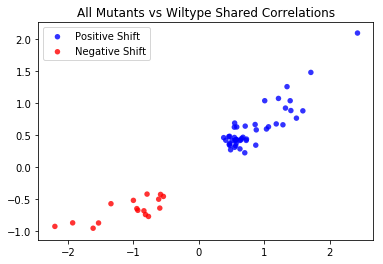

In [11]:
pos = (all_mut_shared_pos_df['mean_dif_txn'], all_mut_shared_pos_df['mean_dif_prot'])
neg = (all_mut_shared_neg_df['mean_dif_txn'], all_mut_shared_neg_df['mean_dif_prot'])
unique = (
    
data = (pos, neg)
colors = ('blue', 'red')
groups = ('Positive Shift', 'Negative Shift')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
 
plt.title('All Mutants vs Wiltype Shared Correlations')
plt.legend(loc=2)
plt.show()

### Negative Directional Shift

### Both Directions